In [1]:
# ライブラリ読み込み
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
import pickle
from tqdm.notebook import tqdm
import japanize_matplotlib
import matplotlib.cm as cm

!pip install japanize-matplotlib

In [2]:
path_1 = "./folder_05/"
file_mesh = 'mesh_list_2021.pickle'
file_hsdn = "hsdn.csv"


In [3]:
#HSDN読込
hsdn = pd.read_csv(path_1+file_hsdn)
print(len(hsdn))
hsdn = hsdn[hsdn["cosine_similarity"]>0.1]#閾値設定
print("--> 閾値cos＞0.1:", len(hsdn))


7804331
--> 閾値cos＞0.1: 1584355


In [4]:
#target疾患のMeSH表記形リスト作成

target_list=["Diabetes Mellitus, Type 2", #2型糖尿病
             "Diabetes Mellitus, Type 1", #1型糖尿病
             "Arthritis, Rheumatoid",  #関節炎・リウマチ
             "Schizophrenia", #統合失調症
             "Frailty", #フレイル
             "Sarcopenia",#サルコペニア
             "Influenza, Human",#インフルエンザ（ヒト）
             "COVID-19", #2021にはないが参考まで
             "Common Cold",#風邪
             "Immunoglobulin G4-Related Disease",#IgG4関連疾患 
             "Sjogren's Syndrome", #シェーグレン症候群
            ]
#target疾患の疾患リンク数
for i in target_list:
    print(i, len(hsdn[(hsdn["disease_1"]==i)|(hsdn["disease_2"]==i)]))

Diabetes Mellitus, Type 2 635
Diabetes Mellitus, Type 1 429
Arthritis, Rheumatoid 1421
Schizophrenia 289
Frailty 108
Sarcopenia 96
Influenza, Human 1203
COVID-19 0
Common Cold 407
Immunoglobulin G4-Related Disease 1232
Sjogren's Syndrome 1215


#target疾患のMeSH表記形リスト作成
#（2型糖尿病、1型糖尿病、関節炎・リウマチ、統合失調症）
target_list = ["Diabetes Mellitus, Type 2", "Diabetes Mellitus, Type 1", "Arthritis, Rheumatoid","Schizophrenia" ]
#target疾患の疾患リンク数
for i in target_list:
    print(i, len(hsdn[(hsdn["disease_1"]==i)|(hsdn["disease_2"]==i)]))

In [5]:
#2021_mesh
with open(file_mesh, 'rb') as f:
    mesh_list = pickle.load(f)

#Zhouらの定義した疾患MeSH
all_disease = [descriptor for descriptor in mesh_list for uid in descriptor[-1] if ((uid.startswith("C")==True) & (uid.startswith("C22")!=True)&(uid.startswith("C23.888")!=True)) | (uid.startswith("F03")==True) ]

#重複削除
disease_mesh = []
[dm for dm in all_disease if dm not in disease_mesh and not disease_mesh.append(dm)]

print("all_mesh:", len(mesh_list), "disease_mesh:", len(disease_mesh))

all_mesh: 29917 disease_mesh: 4887


In [6]:
#treecode単位にMeSHデータをばらす

each_category = [[i[1], category] for i in mesh_list for category in i[2]]
print(len(each_category))

61314


In [7]:
#臓器の日本語名(ja)で分類する

In [8]:
zouki={"胃":['Stomach', 'Gastrointestinal Diseases'],
       "肝臓":['Liver','Liver Diseases'],
       "筋肉":['Muscles', 'Muscular Diseases'],
       "骨格":['Bone and Bones', 'Bone Diseases'],
       "脂肪組織":['Adipose Tissue'],
       "小腸":['Intestine, Small', 'Intestinal Diseases'],
       "心臓":['Heart', 'Heart Diseases'],
       "心臓血管":['Cardiovascular System', 'Cardiovascular Diseases'],
       "腎臓":['Kidney', 'Kidney Diseases'],
       "性腺":['Gonads', 'Gonadal Disorders'],
       "大腸":['Intestine, Large', 'Colonic Diseases'],
       "胆嚢":['Gallbladder', 'Gallbladder Diseases'],
       "虫垂":['Appendix'], 
       "脳":['Brain', 'Brain Diseases'],
       '肺':['Lung', 'Lung Diseases'],
       '皮膚':['Skin', 'Skin Diseases'],
       '末梢神経':['Peripheral Nerves', 'Peripheral Nervous System Diseases'],
       '目':['Eye', 'Eye Diseases'],
       '脾臓':['Spleen', 'Splenic Diseases'],
       '膵臓':['Pancreas', 'Pancreatic Diseases']}
print(zouki)

{'胃': ['Stomach', 'Gastrointestinal Diseases'], '肝臓': ['Liver', 'Liver Diseases'], '筋肉': ['Muscles', 'Muscular Diseases'], '骨格': ['Bone and Bones', 'Bone Diseases'], '脂肪組織': ['Adipose Tissue'], '小腸': ['Intestine, Small', 'Intestinal Diseases'], '心臓': ['Heart', 'Heart Diseases'], '心臓血管': ['Cardiovascular System', 'Cardiovascular Diseases'], '腎臓': ['Kidney', 'Kidney Diseases'], '性腺': ['Gonads', 'Gonadal Disorders'], '大腸': ['Intestine, Large', 'Colonic Diseases'], '胆嚢': ['Gallbladder', 'Gallbladder Diseases'], '虫垂': ['Appendix'], '脳': ['Brain', 'Brain Diseases'], '肺': ['Lung', 'Lung Diseases'], '皮膚': ['Skin', 'Skin Diseases'], '末梢神経': ['Peripheral Nerves', 'Peripheral Nervous System Diseases'], '目': ['Eye', 'Eye Diseases'], '脾臓': ['Spleen', 'Splenic Diseases'], '膵臓': ['Pancreas', 'Pancreatic Diseases']}


In [9]:
cate_ja_list=[]
for key, value in zouki.items():
    for v in value:
        for cate in each_category:
            if cate[0]==v:
                cate_ja_list.append([key, cate[0],cate[-1]])
print(len(cate_ja_list))
cate_ja = pd.DataFrame(cate_ja_list, columns=["ja", "en", "treecode"])

47


In [10]:
#treecode単位でばらしたMeSHデータのうち日本語分類cate_jaのtreecodeに属しているもの を取り出す
cate_ja_df= pd.DataFrame()
for term in each_category:
    for ja, treecode in zip(cate_ja["ja"], cate_ja["treecode"]):
        if term[1].startswith(treecode):
            tmp_df = pd.DataFrame([term[0], term[1], ja, treecode]).T
            cate_ja_df = pd.concat([cate_ja_df, tmp_df], axis=0)
cate_ja_df.columns=["disease_2", "mesh_treecode", "ja", "ja_mesh_treecode"]
cate_ja_df = cate_ja_df.reset_index(drop=True)
print(len(cate_ja_df))
cate_ja_df

4329


,disease_2,mesh_treecode,ja,ja_mesh_treecode
0,Abdominal Muscles,A02.633.567.050,筋肉,A02.633
1,Abducens Nerve,A08.800.800.120.030,末梢神経,A08.800.800
2,Acantholysis,C17.800.865.070,皮膚,C17.800
3,Acanthosis Nigricans,C17.800.621.430.530.100,皮膚,C17.800
4,Accessory Nerve,A08.800.800.120.060,末梢神経,A08.800.800
...,...,...,...,...
4324,Periamygdaloid Cortex,A08.186.211.200.885.287.500.382.750.612,脳,A08.186.211
4325,Organum Vasculosum,A08.186.211.180.497.342.231,脳,A08.186.211
4326,Organum Vasculosum,A08.186.211.200.317.357.342.315,脳,A08.186.211
4327,Organum Vasculosum,A08.186.211.200.885.287.500.620.374.500,脳,A08.186.211


In [11]:
zouki_list = list(zouki.keys())

In [12]:
#色 Pastel1
color_list = ["#fbb4ae", "#b3cde3", "#ccebc5", "#decbe4", "#fed9a6", "#ffffcc", "#e5d8bd", "#fddaec", "#f2f2f2" ]

In [13]:
#器官系別に色を塗る

category_color = {}
for i in zouki_list:
    #神経系
    if (i == "脳") | (i=="末梢神経"):
        category_color = {**category_color,**dict([(i, color_list[0])])}
    #循環器系 
    if (i == "心臓") | (i=="心臓血管") | (i=="脾臓"):
        category_color = {**category_color,**dict([(i, color_list[1])])}
    #消化器系
    if (i == "胆嚢") | (i=="虫垂") | (i=="大腸") | (i=="膵臓") | (i=="小腸") | (i=="胃") | (i=="肝臓"):
        category_color = {**category_color,**dict([(i, color_list[2])])}            
    #感覚器系
    if (i == "皮膚") | (i=="目"):
        category_color = {**category_color,**dict([(i, color_list[3])])}
    #筋骨格系
    if (i == "筋肉") | (i=="骨格"): 
        category_color = {**category_color,**dict([(i, color_list[4])])}
    #呼吸器系
    if (i == "肺"):
        category_color = {**category_color,**dict([(i, color_list[5])])}
    #内分泌系
    if (i == "性腺") :
        category_color = {**category_color,**dict([(i, color_list[6])])}
    #泌尿器系
    if (i == "腎臓") :
        category_color = {**category_color,**dict([(i, color_list[7])])}

In [14]:
#グラフの設定
color_data = pd.DataFrame(list(category_color.items()),  columns=['zouki', 'color'])
plt.style.use('ggplot')
plt.rcParams.update({'font.size':12})
size=(5,4)#横長に

In [15]:
#円グラフ作成関数の定義

def make_pie(target):
    
    #disease_1列がtargetのもの
    tmp_df = hsdn[(hsdn["disease_1"]==target)].reset_index(drop=True)
    #disease_2列がtargetのもの
    tmptmp_df = hsdn[(hsdn["disease_2"]==target)][["disease_2", "disease_1","cosine_similarity"]].reset_index(drop=True)
    #tmp_dfと合体させるため列名を変更
    tmptmp_df = tmptmp_df.rename(columns={"disease_2":"disease_1", "disease_1":"disease_2"})
    #合体
    df = pd.concat([tmp_df, tmptmp_df], axis=0)
    df = df.sort_values(by="cosine_similarity", ascending=False)
    df = df.reset_index(drop=True)
    print(len(df))

    target_with_category= pd.merge(df, cate_ja_df, on="disease_2")
    
    #save data
    #target_with_category.to_csv("../figure/"+target+"_2022.tsv", sep="\t",index=False)
    
    pie_data_ = target_with_category.value_counts("ja")
    pie_data = pd.DataFrame(list(pie_data_.items()),  columns=['zouki', 'value'])
    pie = pd.merge(pie_data, color_data, on="zouki")    
    print(pie[['zouki', 'value']])
    
    labels = pie["zouki"].tolist()
    data =  pie["value"].tolist()
    category_color = dict(zip(pie["zouki"], pie['color']))

    plt.figure(figsize=size, dpi=100)
    plt.pie(data,
            labels=labels,
            colors=[category_color[key] for key in labels],
            counterclock=False,
            startangle=90,
            #比率が3%未満であれば表示しない
            autopct=lambda p:'{:.1f}%'.format(p) if p>=3 else '', #autopct='%1.1f%%',
           )
    
    plt.subplots_adjust(left=0, right=0.7)
    #plt.legend(labels, fancybox=True,loc='center left',bbox_to_anchor=(0.9,0.5)) 
    plt.axis('equal') 
    
    #save figure
    #plt.savefig("./figure/"+target+'_2021.png',bbox_inches='tight',pad_inches=0.05)
    
    plt.title(target,loc='right',fontsize=14)
    
    plt.tight_layout()
    plt.show()


635
   zouki  value
0     腎臓     92
1   心臓血管     66
2      胃     35
3     皮膚     29
4     肝臓     27
5     骨格     24
6      脳     24
7     心臓     23
8     小腸     16
9      目     13
10     肺     11
11    性腺      9
12    膵臓      7
13    大腸      4
14  末梢神経      4
15    胆嚢      2
16    筋肉      2


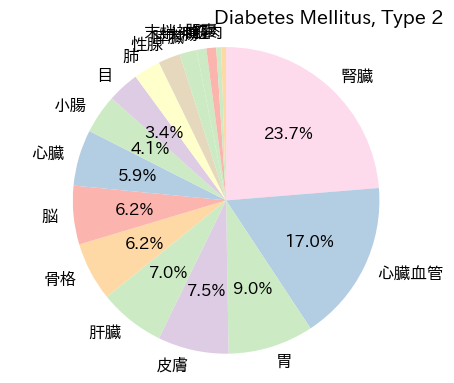

429
   zouki  value
0     腎臓     94
1   心臓血管     40
2     皮膚     21
3      胃     20
4     肝臓     17
5      目     13
6      脳     13
7     骨格     13
8     心臓     10
9     小腸      9
10    性腺      8
11  末梢神経      3
12     肺      3
13    膵臓      3
14    大腸      2


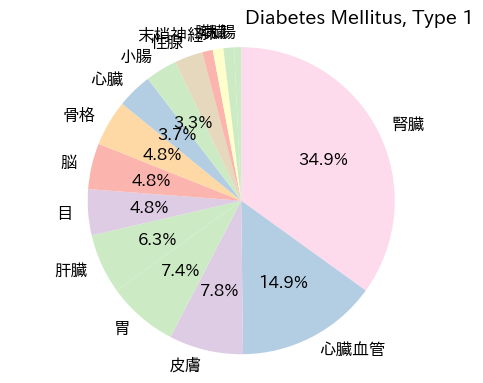

1421
   zouki  value
0     皮膚    166
1     骨格    109
2   心臓血管     93
3     腎臓     88
4      胃     68
5     筋肉     49
6   末梢神経     49
7     小腸     38
8      目     35
9      脳     27
10    肝臓     24
11     肺     19
12    心臓     18
13    性腺     12
14    膵臓     10
15    大腸      7
16    胆嚢      2


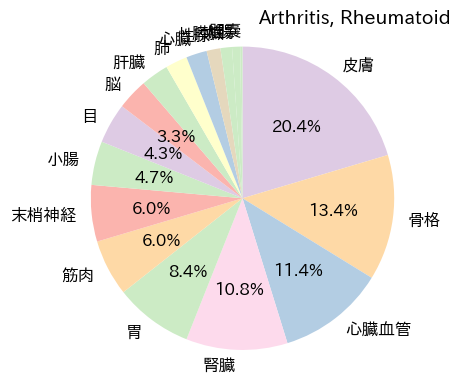

289
  zouki  value
0     脳     95
1  心臓血管     35
2    皮膚      6
3    肝臓      6
4    心臓      3
5    性腺      3
6     目      1
7     肺      1
8    骨格      1


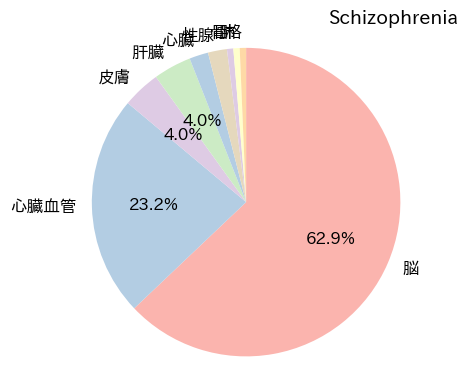

108
   zouki  value
0      胃     20
1     肝臓     16
2     小腸      9
3   心臓血管      8
4     皮膚      5
5     心臓      4
6     腎臓      4
7     性腺      3
8     筋肉      3
9      肺      3
10    膵臓      3
11    骨格      3
12    大腸      2
13     脳      2
14     目      1


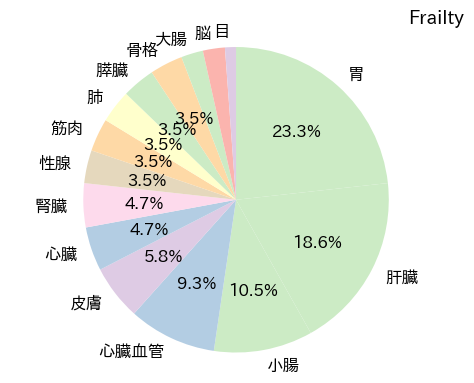

96
   zouki  value
0      胃     20
1     肝臓     16
2     小腸      9
3   心臓血管      7
4     皮膚      6
5     心臓      3
6     性腺      3
7      肺      3
8     膵臓      3
9     骨格      3
10    大腸      2
11    筋肉      2
12     脳      2
13    腎臓      2
14     目      1


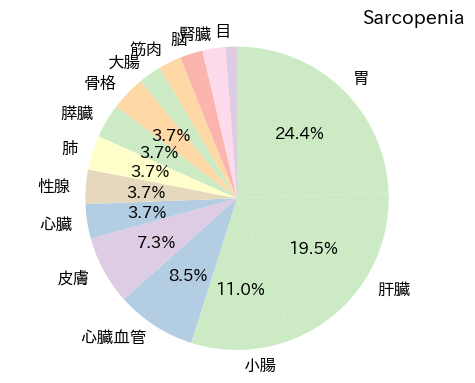

1203
   zouki  value
0   心臓血管    140
1      肺     98
2      脳     96
3     皮膚     88
4      胃     57
5     心臓     35
6     小腸     24
7     肝臓     23
8     腎臓     18
9     筋肉     12
10    骨格     10
11     目     10
12  末梢神経      4
13    脾臓      4
14    大腸      4
15    胆嚢      3
16    性腺      1
17    膵臓      1


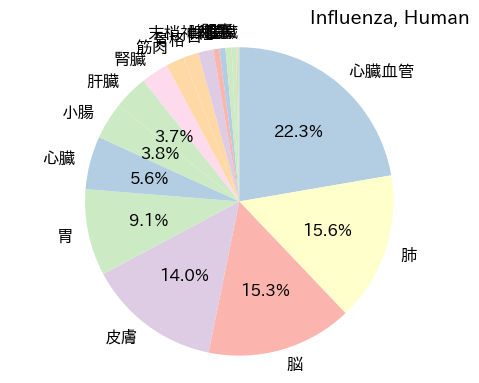

0
Empty DataFrame
Columns: [zouki, value]
Index: []


<ipython-input-15-d32cab5db93d>:32: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  plt.pie(data,


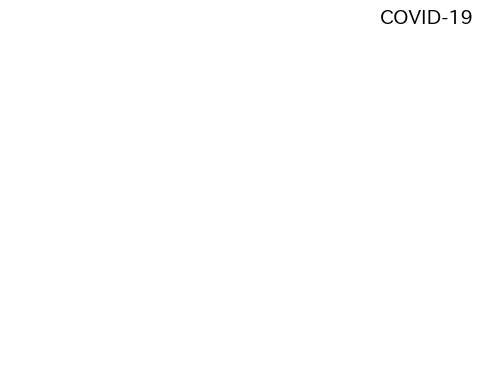

407
   zouki  value
0      肺     89
1   心臓血管     35
2     皮膚     20
3     心臓     11
4      胃     11
5      脳      6
6     肝臓      5
7     腎臓      4
8      目      3
9     筋肉      3
10  末梢神経      2
11    骨格      2
12    膵臓      1


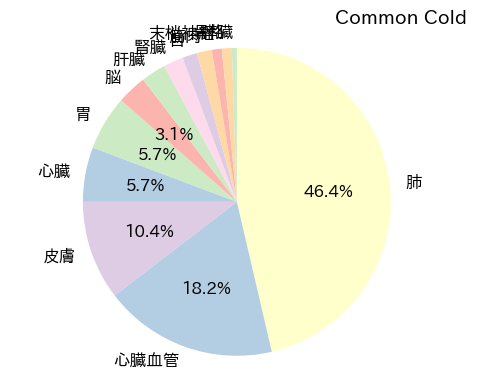

1232
   zouki  value
0   心臓血管    115
1     腎臓    106
2     皮膚     93
3     骨格     90
4      肺     89
5     肝臓     47
6      胃     31
7      目     25
8     心臓     25
9     筋肉     22
10     脳     17
11  末梢神経     15
12    膵臓     12
13    小腸     10
14    性腺      5
15    胆嚢      5
16    脾臓      4
17    大腸      1


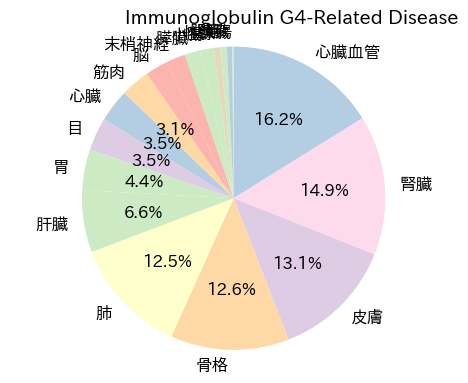

1215
   zouki  value
0     皮膚    250
1   心臓血管     89
2      脳     68
3     骨格     45
4   末梢神経     41
5     筋肉     38
6      胃     38
7      目     28
8      肺     26
9     腎臓     26
10    肝臓     23
11    小腸     17
12    心臓     11
13    膵臓      6
14    性腺      4
15    大腸      3


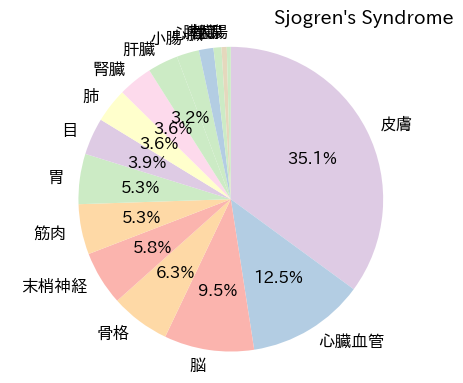

In [16]:
#実行
for target in target_list:
    make_pie(target)